# Daria Plewa
## r0976669
## Spatial analysis with Scanpy of lung cancer tissue

This notebook details our spatial analysis workflow of human lung cancer tissue, leveraging the Scanpy library and data from 10x Genomics. Through meticulous preprocessing, we address data compatibility issues, followed by comprehensive quality control to filter out doublets and stressed cells. Subsequent steps include normalization, PCA, clustering, and the exploration of spatially variable genes to deduce their functional roles in specific tissue regions. Our findings reveal distinct gene expression patterns, offering insights into the molecular landscape of lung cancer and highlighting potential areas for further investigation.

# Introduction

Spatial analysis was performed with the data coming from 10xgenomics.com, from dataset human-lung-cancer-ffpe, https://www.10xgenomics.com/resources/datasets/human-lung-cancer-ffpe-2-standard. The data was processed, analyzed and the results were presented in screens or plots.

# First data processing for further analysis

### Preprocessing of data was crucial due to issue with Scanpy library and difference in types of imported data - adata.obsm['spatial'] to be more precise.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import scanpy as sc

In [2]:
outdir = "/mnt/storage/" + os.environ['USER'] + "/regulatoryGenomics2023/SpatialTrascriptomics"
os.makedirs(outdir, exist_ok=True)

In [3]:
path_data =  "/mnt/storage/" + os.environ['USER'] + '/jupyternotebooks/Task_1/outs'
os.listdir(path_data)

['spatial',
 '.ipynb_checkpoints',
 'filtered_feature_bc_matrix.h5',
 'raw_feature_bc_matrix.h5']

In [4]:
adata = sc.read_visium(path_data)
adata.var_names_make_unique()

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata.obsm['spatial'] = adata.obsm['spatial'].astype(int)

In [6]:
adata

AnnData object with n_obs × n_vars = 3858 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

# Quality Control

### In quality control I would show genes that obtain the highest amount of counts within cells, later I would filter the cells that contain at least 100 genes that are expressed in at least 10 cells. Finally with the use of Scrublet I would estimate doublets, and omit them in further analysis. Additionaly I would remove cells that show elevated expression of mitochondrial genes, that could point out the stress or apaptosis behaviours.

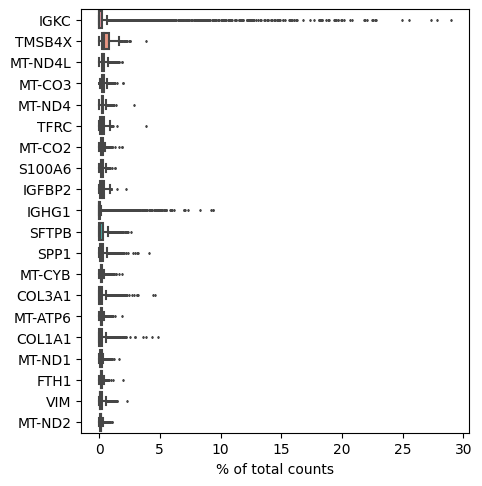

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20,)

In [8]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

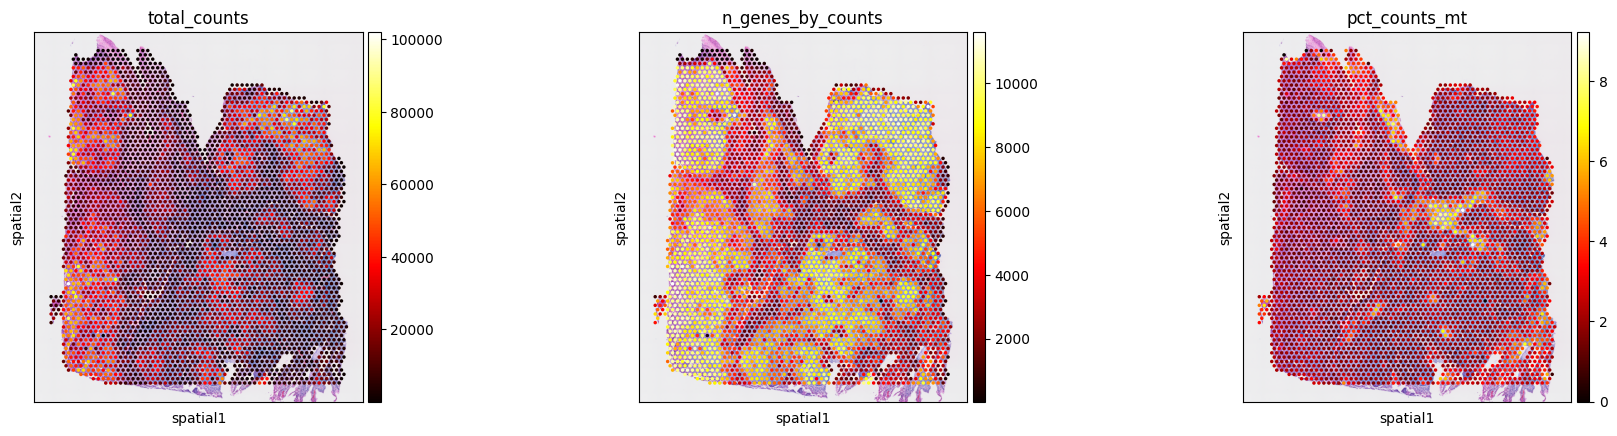

In [9]:
sc.pl.spatial(adata, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], cmap='hot')

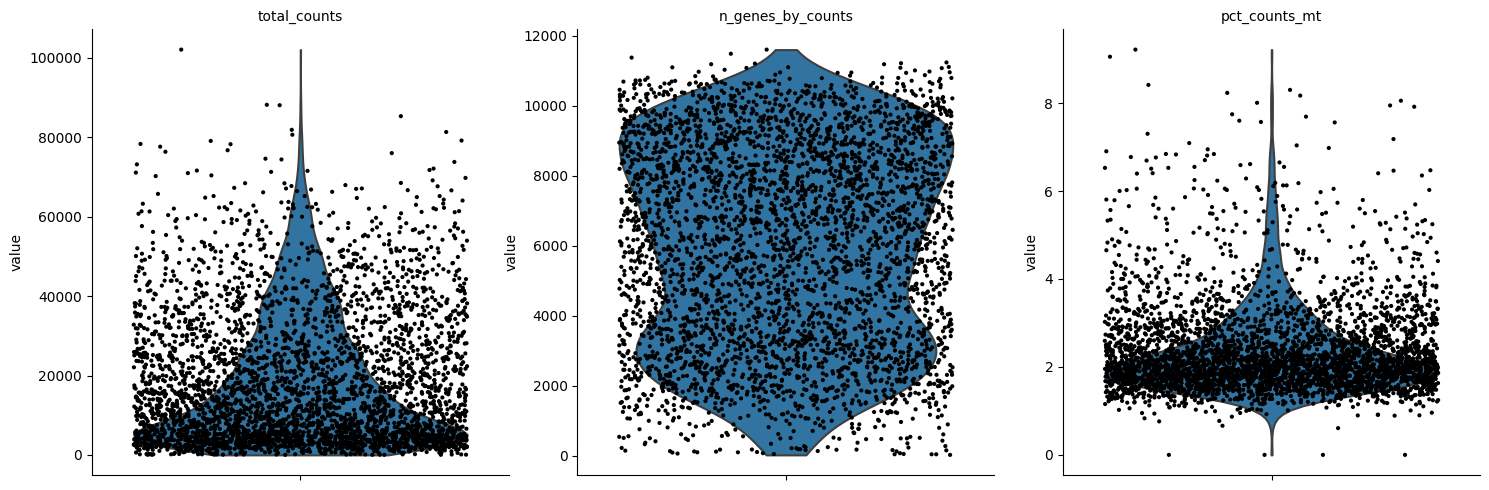

In [10]:
sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, size=3)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

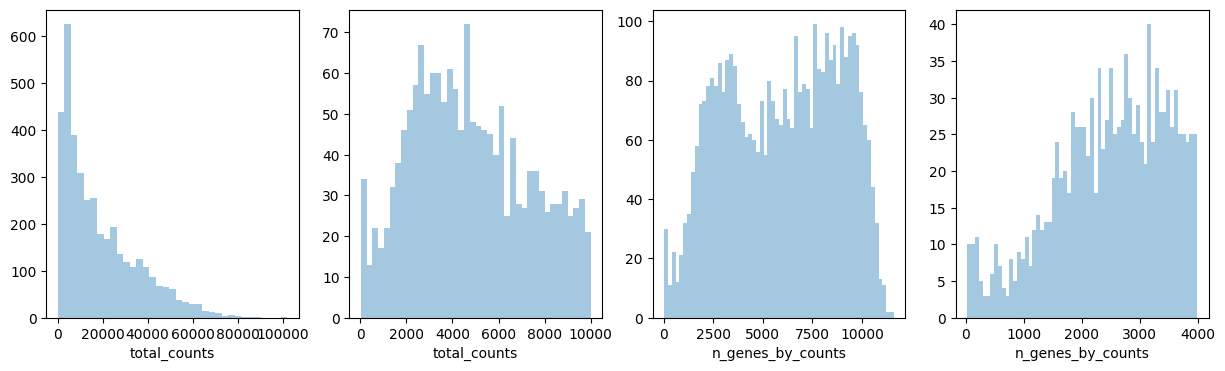

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [12]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=10)

In [13]:
sc.external.pp.scrublet(adata)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.1%


In [14]:
adata = adata[adata.obs['predicted_doublet'] == False]
adata

View of AnnData object with n_obs × n_vars = 3844 × 18039
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'scrublet'
    obsm: 'spatial'

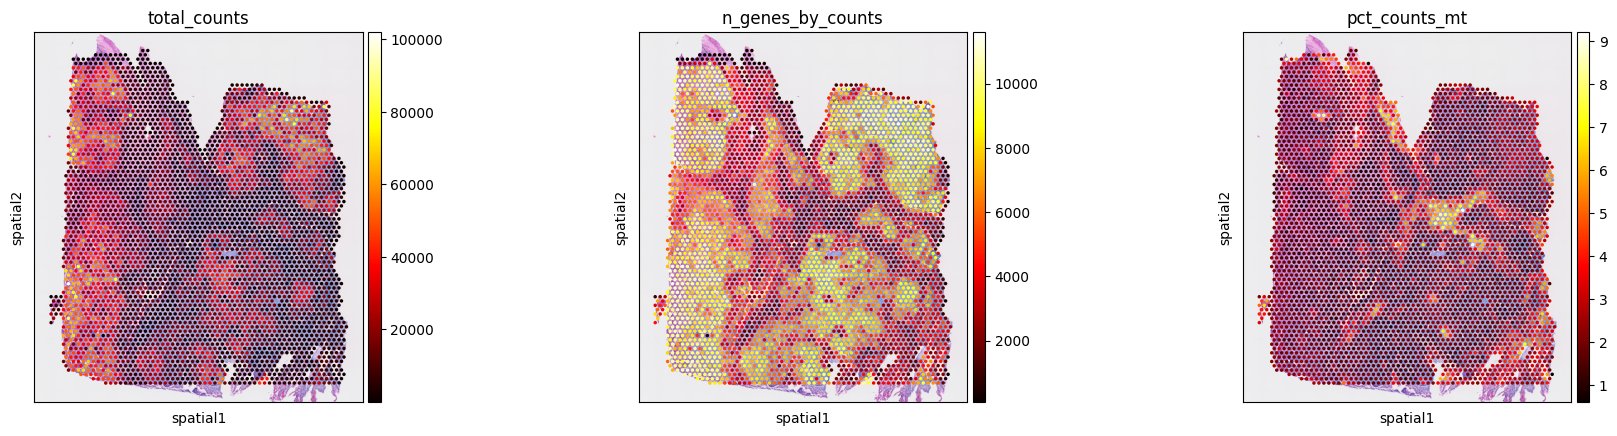

In [15]:
sc.pl.spatial(adata, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], cmap='hot')

In [16]:
sc.pp.calculate_qc_metrics(adata, qc_vars=[], percent_top=None, log1p=False, inplace=True)
adata

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


AnnData object with n_obs × n_vars = 3844 × 18039
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'scrublet'
    obsm: 'spatial'

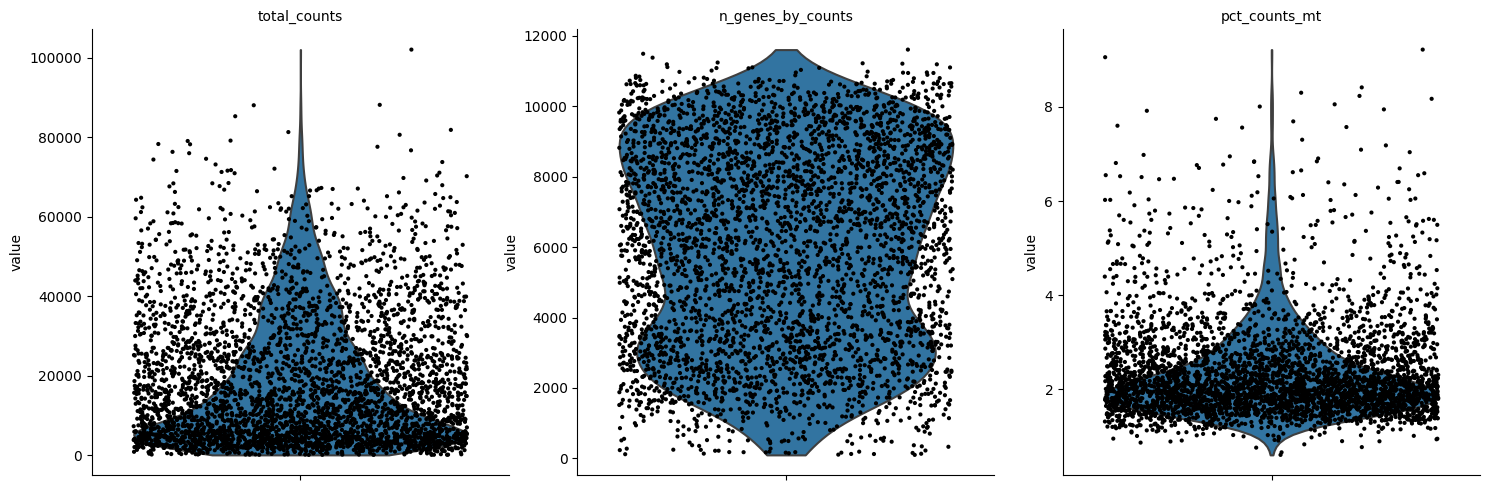

In [17]:
sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, size=3)

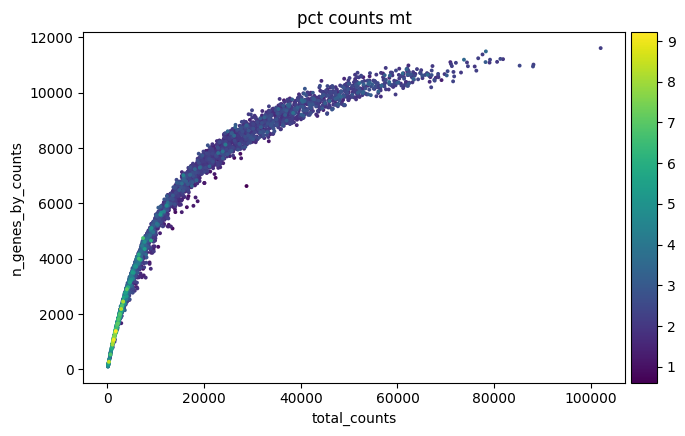

In [18]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

In [19]:
upper = np.quantile(adata.obs.pct_counts_mt.values, .975)
lower = np.quantile(adata.obs.pct_counts_mt.values, .025)
print(lower, upper)

1.2450119137763977 5.485338926315306


In [20]:
adata = adata[(adata.obs.pct_counts_mt < upper) & (adata.obs.pct_counts_mt > lower)]

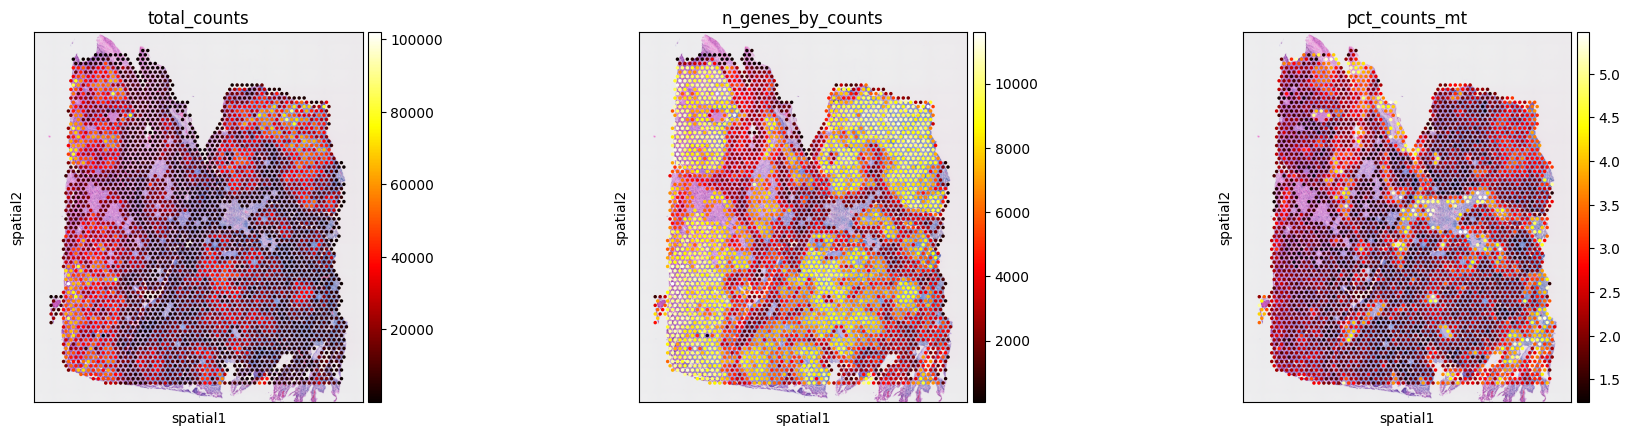

In [21]:
sc.pl.spatial(adata, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], cmap='hot')

# Normalization

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['lognorm'] = adata.X
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


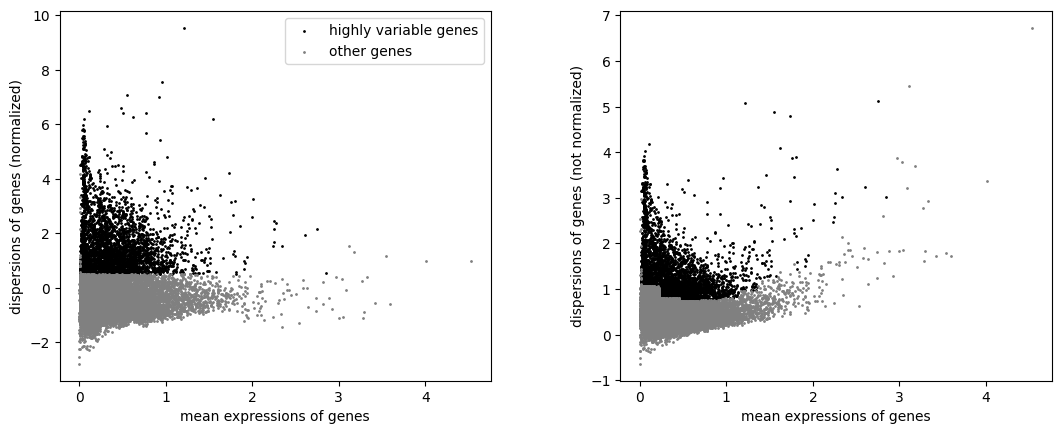

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
adata = adata[:, adata.var.highly_variable]


sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


sc.pp.scale(adata, max_value=7)

adata

AnnData object with n_obs × n_vars = 3650 × 3832
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'spatial', 'scrublet', 'log1p', 'hvg'
    obsm: 'spatial'
    layers: 'lognorm'

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


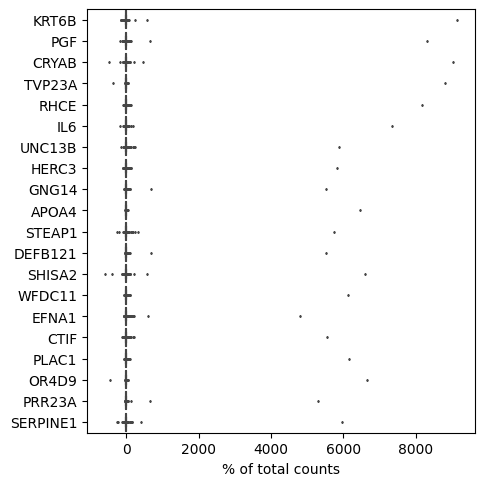

In [25]:
sc.pl.highest_expr_genes(adata, n_top=20,)

# PCA

In [26]:
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)

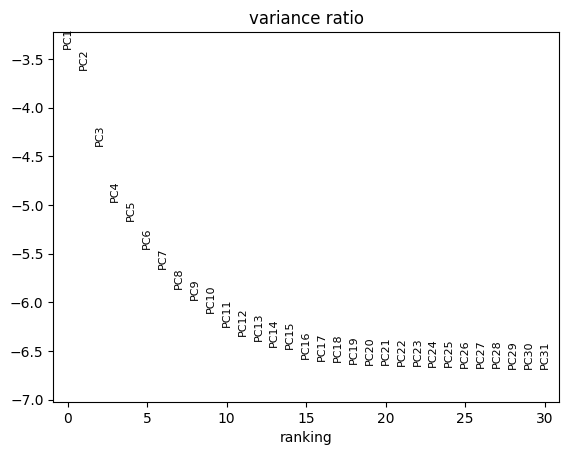

In [27]:
sc.pl.pca_variance_ratio(adata, log=True)

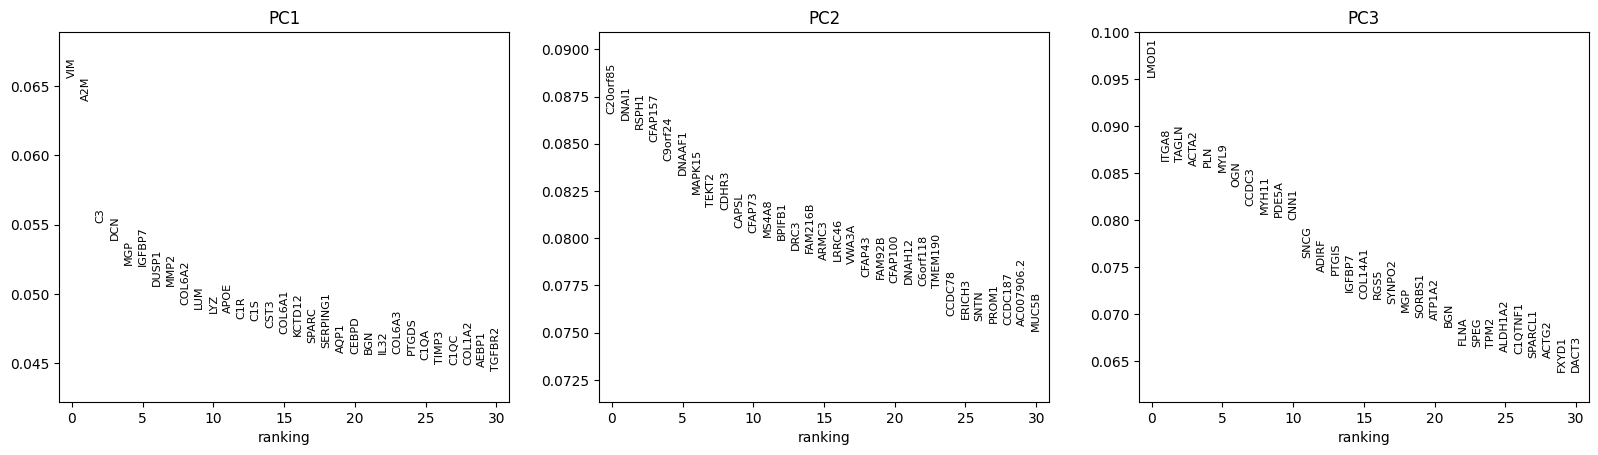

In [28]:
sc.pl.pca_loadings(adata, include_lowest=False)

# Clustering

In [63]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters", resolution = 0.3)

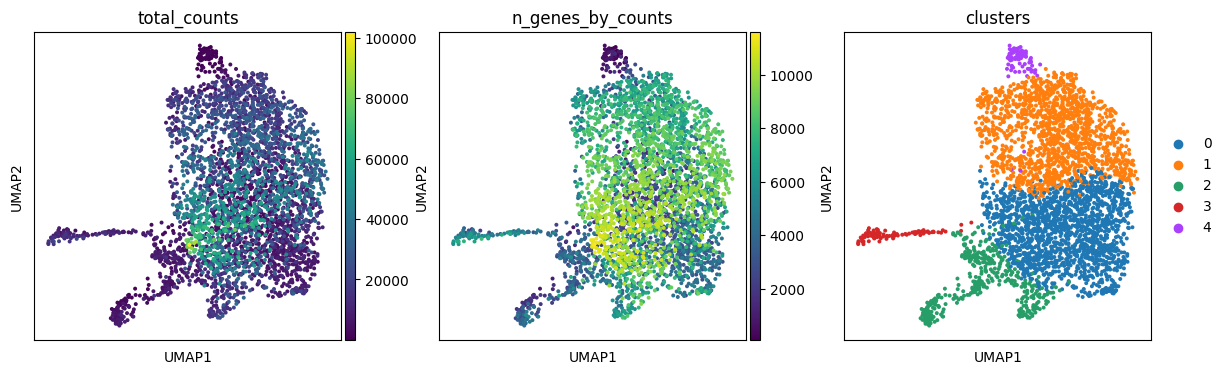

In [64]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.2)

In [74]:
sc.tl.leiden(adata, resolution=0.3)
sc.tl.dendrogram(adata, groupby='clusters')

# Cluster Marker Genes

In [71]:
sc.tl.rank_genes_groups(adata, "clusters", method="wilcoxon")

categories: 0, 1, 2, etc.
var_group_labels: 3


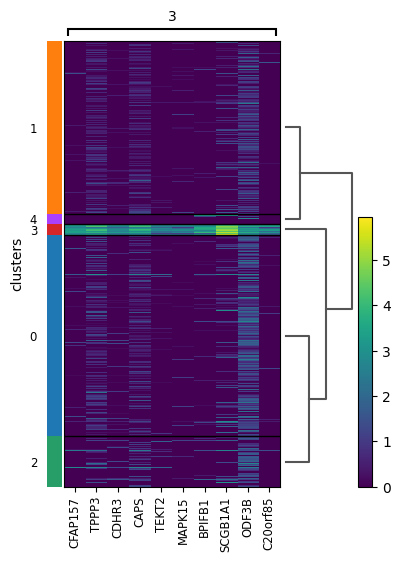

In [79]:
sc.pl.rank_genes_groups_heatmap(adata, groups="3", n_genes=10, groupby="clusters")

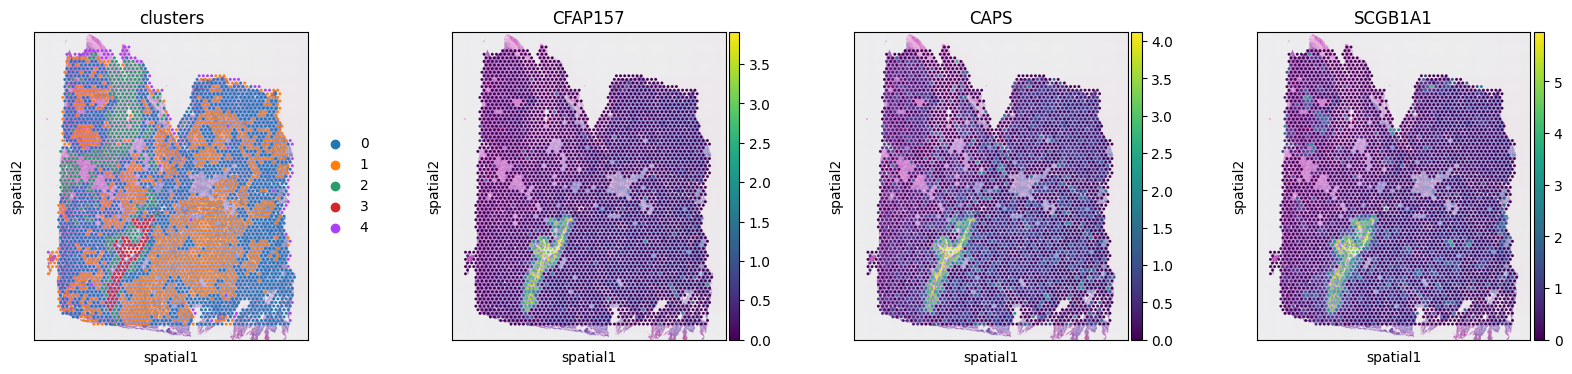

In [77]:
sc.pl.spatial(adata, img_key="hires", color=["clusters", "CFAP157", "CAPS", "SCGB1A1"])

# Spatially Variable Genes

In [80]:
import SpatialDE

In [81]:
counts = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)
coord = pd.DataFrame(adata.obsm['spatial'], columns=['x_coord', 'y_coord'], index=adata.obs_names)
results = SpatialDE.run(coord, counts)

/home/luna.kuleuven.be/r0976669/.local/lib/python3.8/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/home/luna.kuleuven.be/r0976669/.local/lib/python3.8/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/3832 [00:00<?, ?it/s]

/home/luna.kuleuven.be/r0976669/.local/lib/python3.8/site-packages/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)


  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/3832 [00:00<?, ?it/s]

In [85]:
results.index = results["g"]
adata.var = pd.concat([adata.var, results.loc[adata.var.index.values, :]], axis=1)

In [135]:
results.sort_values("qval").head(10)

FSV  M         g            l  max_delta       max_ll  \
g                                                                      
PPP1R13L  0.080015  4  PPP1R13L  1271.684587  11.266251 -5108.142358   
FANK1     0.376195  4     FANK1   665.795049   1.648830 -4567.028943   
PLEKHS1   0.403639  4   PLEKHS1   665.795049   1.469116 -4539.417047   
CFAP43    0.599057  4    CFAP43   665.795049   0.665512 -3908.967599   
SORBS1    0.329532  4    SORBS1   665.795049   2.023114 -4724.494604   
LIPA      0.238056  4      LIPA   665.795049   3.182618 -4964.523101   
ACTA2     0.523829  4     ACTA2   665.795049   0.903886 -4167.977223   
ADIRF     0.386535  4     ADIRF   665.795049   1.578123 -4526.921922   
SNCG      0.345165  4      SNCG   665.795049   1.886455 -4629.791262   
SFTPD     0.537462  4     SFTPD   665.795049   0.855737 -4245.842528   

          max_mu_hat  max_s2_t_hat model     n    s2_FSV  s2_logdelta  \
g                                                                       
PPP1R13L   -0.005886      0.081715    SE  3650  0.000011     0.001711   
FANK1      -0.017206      0.346230    SE  3650  0.000003     0.000069   
PLEKHS1    -0.014826      0.377264    SE  3650  0.000003     0.000066   
CFAP43     -0.021508      0.525553    SE  3650  0.000002     0.000038   
SORBS1     -0.016401      0.315123    SE  3650  0.000004     0.000092   
LIPA        0.014182      0.239510    SE  3650  0.000006     0.000185   
ACTA2      -0.026246      0.467792    SE  3650  0.000003     0.000054   
ADIRF      -0.029603      0.351997    SE  3650  0.000003     0.000064   
SNCG       -0.025771      0.318305    SE  3650  0.000003     0.000075   
SFTPD      -0.007729      0.511393    SE  3650  0.000003     0.000059   

              time           BIC  max_ll_null          LLR  pval  qval  
g                                                                       
PPP1R13L  0.012741  10249.094645 -5178.625646    70.483288   0.0   0.0  
FANK1     0.007411   9166.867817 -5178.625646   611.596703   0.0   0.0  
PLEKHS1   0.004322   9111.644025 -5178.625646   639.208599   0.0   0.0  
CFAP43    0.003793   7850.745127 -5178.625659  1269.658061   0.0   0.0  
SORBS1    0.004826   9481.799138 -5178.625646   454.131042   0.0   0.0  
LIPA      0.005139   9961.856132 -5178.625646   214.102545   0.0   0.0  
ACTA2     0.003438   8368.764377 -5178.625646  1010.648423   0.0   0.0  
ADIRF     0.005019   9086.653775 -5178.625646   651.703724   0.0   0.0  
SNCG      0.004375   9292.392455 -5178.625659   548.834397   0.0   0.0  
SFTPD     0.003933   8524.494987 -5178.625646   932.783118   0.0   0.0

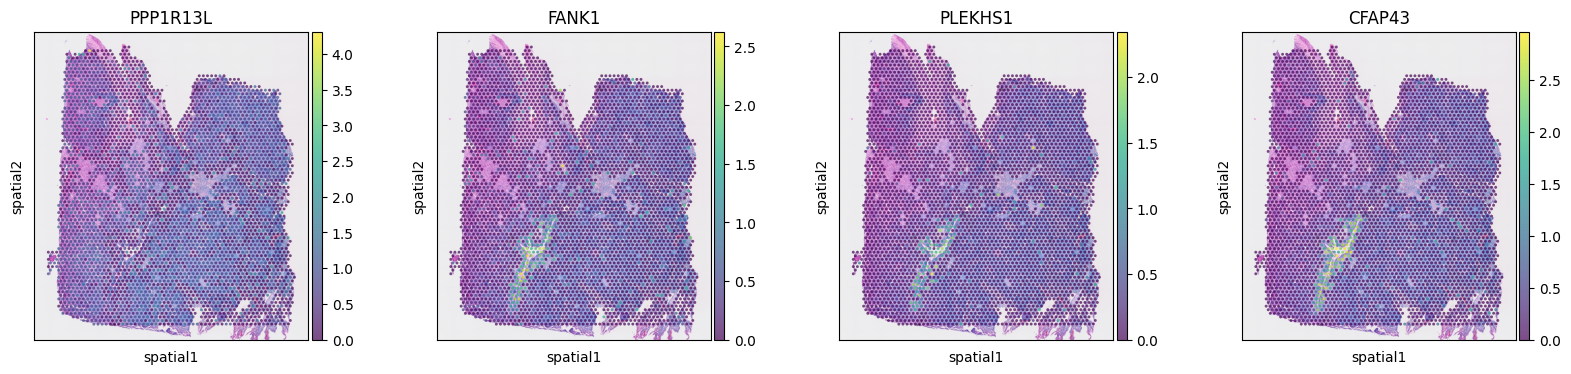

In [87]:
sc.pl.spatial(adata, img_key="hires", color=["PPP1R13L", "FANK1", 'PLEKHS1', 'CFAP43'], alpha=0.7)

# Functional Analysis

In [93]:
from matplotlib.pyplot import rc_context

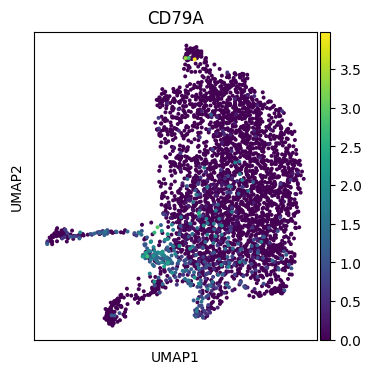

In [95]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color='CD79A')

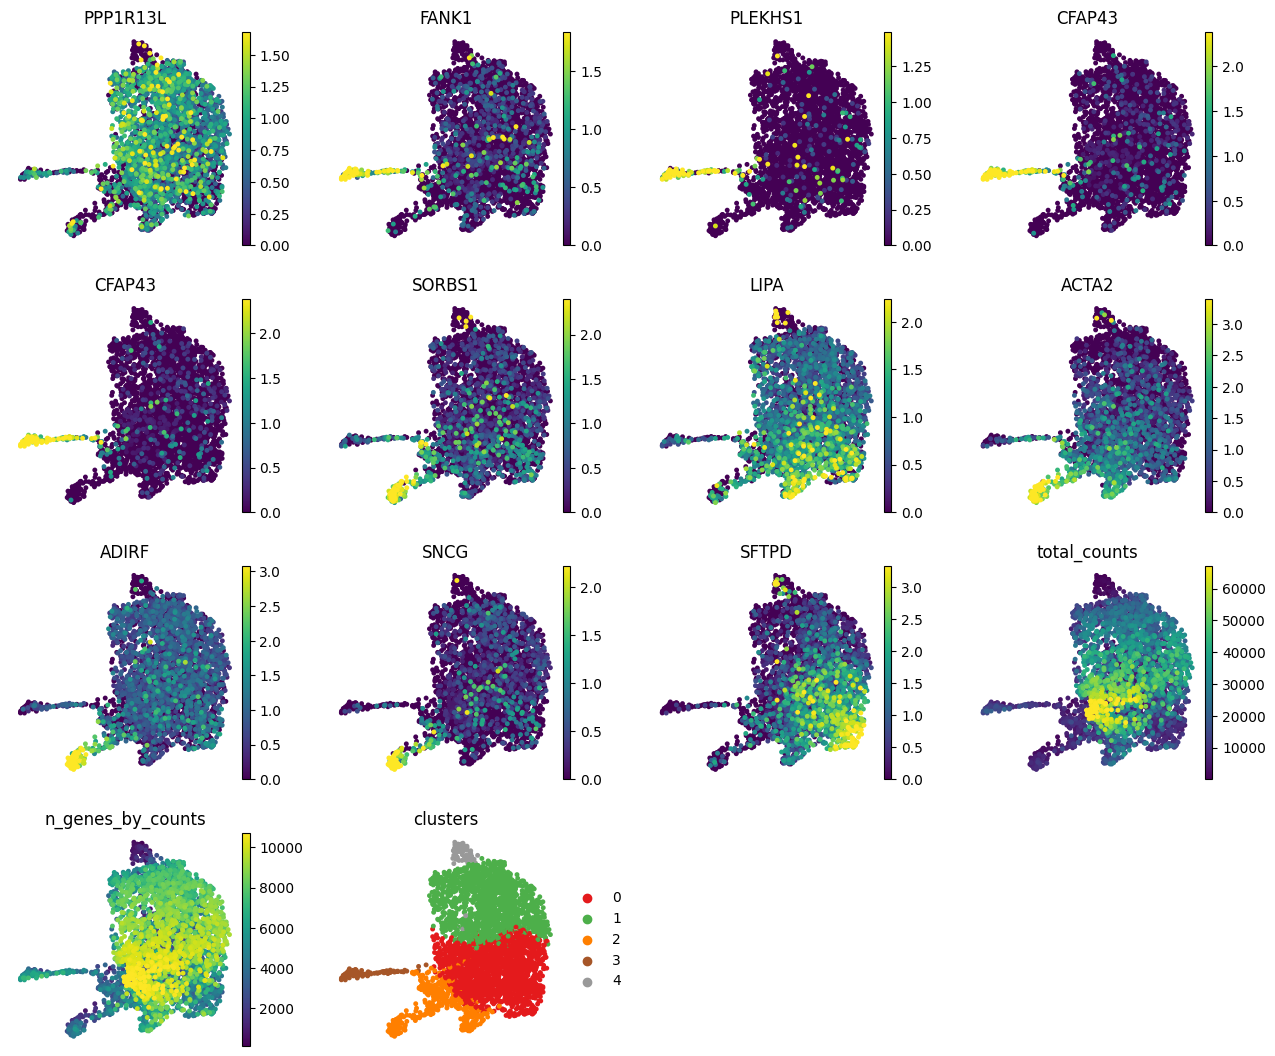

In [136]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(adata, color=["PPP1R13L", "FANK1", 'PLEKHS1', 'CFAP43','CFAP43','SORBS1','LIPA', 'ACTA2','ADIRF', 'SNCG','SFTPD', "total_counts", "n_genes_by_counts", "clusters"], s=50, frameon=False, ncols=4, vmax='p99')

In [103]:
sc.tl.leiden(adata, key_added='clusters', resolution=0.3)

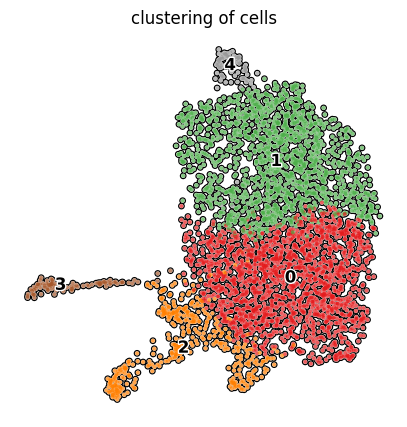

In [104]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color='clusters', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='clustering of cells', palette='Set1')

In [141]:
marker_genes_dict = {
    '0': ['SFTPD', 'LIPA'],
    '2': ['SORBS1', 'ACTA2','ADIRF','SNCG'],
    '3': ['CFAP43', 'PLEKHS1', 'FANK1','CFAP43']
}

categories: 0, 1, 2, etc.
var_group_labels: 0, 2, 3


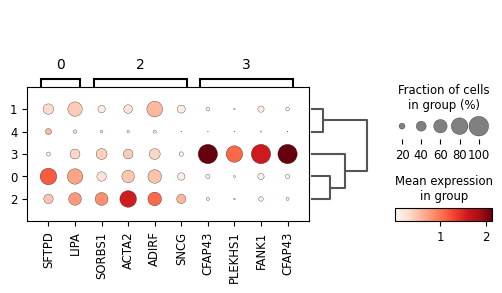

In [142]:
sc.pl.dotplot(adata, marker_genes_dict, 'clusters', dendrogram=True)

In [148]:
cluster2annotation = {
     '2': 'tissue development,',
     '3': 'cilia formation and function'
}


adata.obs['cell type'] = adata.obs['clusters'].map(cluster2annotation).astype('category')

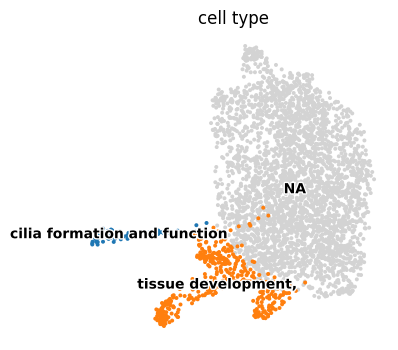

In [149]:
sc.pl.umap(adata, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

### For functional analysis were picked the genes that were spatiably variable. Later genes were assigned to their common function in each region. For more advanced analysis could be picked more genes - but basing on the results that I recived i could expect that in 3rd region could mostly appear genes responsible for cilia formation and development when in 2 tissue development. Other genes showed bigger scatter across plot, and their functions significantly differed from each other. Additionaly from plots presenting the amount of genes by counts across the cluster plot, we can clearly see that most of genes appear in 0 and 1 localization of cluster, while in 2,3,4 and 5 appear less genes, yet with more common functions. Consequenlty we can assume that those regions have specified genes basing on certain functions.